In [10]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [11]:
works_in_tech = pd.read_csv('works_in_tech.csv')
works_in_tech.dropna(subset=['work_interfere'], inplace=True)
works_in_tech.info()

<class 'pandas.core.frame.DataFrame'>
Index: 810 entries, 0 to 1023
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  810 non-null    object
 1   Age                        810 non-null    int64 
 2   Gender                     810 non-null    object
 3   Country                    810 non-null    object
 4   state                      491 non-null    object
 5   self_employed              794 non-null    object
 6   family_history             810 non-null    object
 7   treatment                  810 non-null    object
 8   work_interfere             810 non-null    object
 9   no_employees               810 non-null    object
 10  remote_work                810 non-null    object
 11  tech_company               810 non-null    object
 12  benefits                   810 non-null    object
 13  care_options               810 non-null    object
 14  wellness_progr

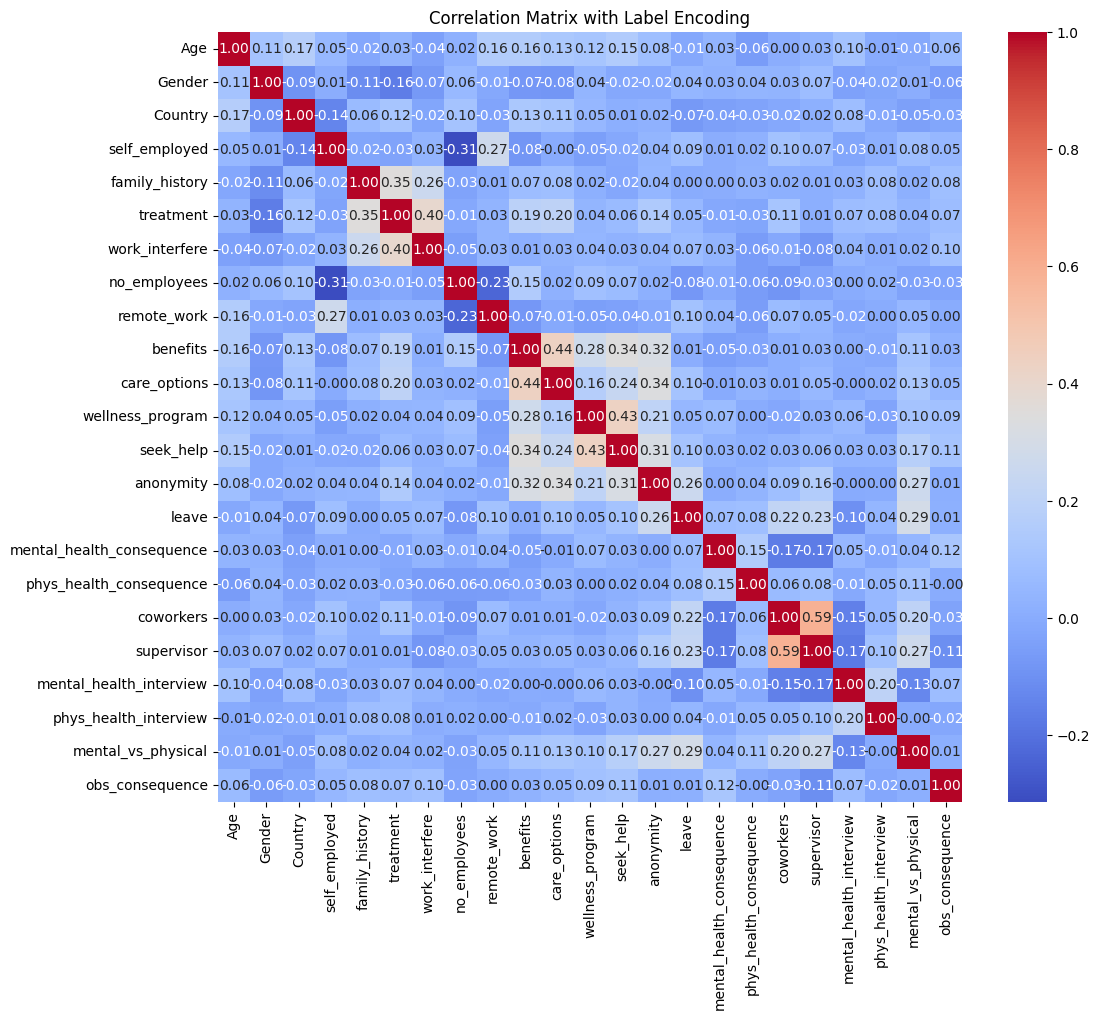

In [12]:
cols_to_drop = ['Timestamp', 'comments', 'state', 'tech_company']
works_in_tech_encoded = works_in_tech.drop(columns=cols_to_drop)
for col in works_in_tech_encoded.columns:
	if col == 'work_interfere':
		works_in_tech_encoded[col] = works_in_tech_encoded[col].map({
			'Often': 1, 'Sometimes': 1,
			'Rarely': 0, 'Never': 0
		})
	elif works_in_tech_encoded[col].dtype == 'object':
		works_in_tech_encoded[col] = LabelEncoder().fit_transform(works_in_tech_encoded[col])
corr = works_in_tech_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix with Label Encoding")
plt.show()

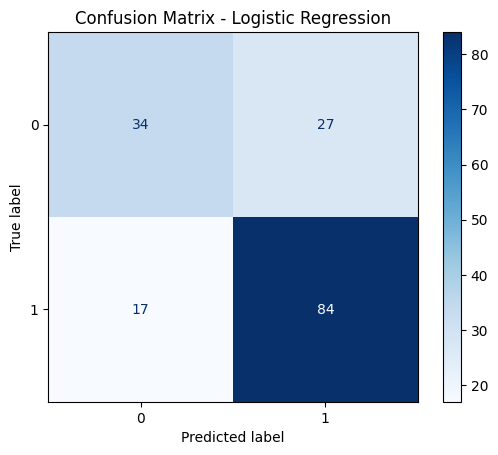

              precision    recall  f1-score   support

           0       0.67      0.56      0.61        61
           1       0.76      0.83      0.79       101

    accuracy                           0.73       162
   macro avg       0.71      0.69      0.70       162
weighted avg       0.72      0.73      0.72       162



In [13]:
# --- Features & Target ---
features = ['Age', 'family_history', 'treatment', 'leave', 'care_options', 'Country']
target = 'work_interfere'  # Yes / No

# X and y
X = works_in_tech[features].copy()
y = works_in_tech[target].map({
    'Often': 1, 'Sometimes': 1,   # collapse into 1
    'Rarely': 0, 'Never': 0,       # collapse into 0
})

# --- One-Hot Encode categorical column ---
# X = pd.get_dummies(X, drop_first=True)
for col in X.columns:
	X[col] = LabelEncoder().fit_transform(X[col])
# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Standard Scaler ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # Fit on train, transform train
X_test_scaled = scaler.transform(X_test)         # Transform test using same scaler

# --- Train Logistic Regression ---
model = LogisticRegression(max_iter=1000)  # increase iterations just in case
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# --- Classification Report ---
print(classification_report(y_test, y_pred))

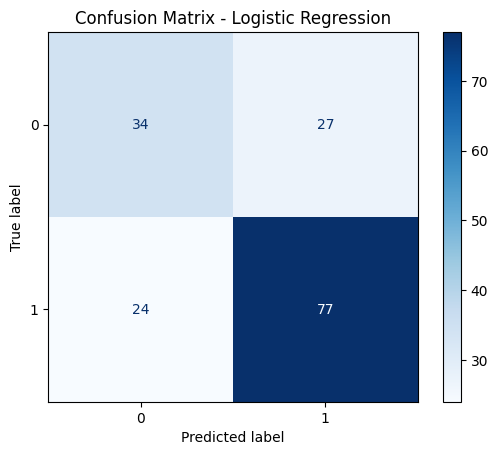

              precision    recall  f1-score   support

           0       0.59      0.56      0.57        61
           1       0.74      0.76      0.75       101

    accuracy                           0.69       162
   macro avg       0.66      0.66      0.66       162
weighted avg       0.68      0.69      0.68       162



In [14]:
features = 'treatment'
target = 'work_interfere'  # Yes / No
X = works_in_tech[features].copy()
y = works_in_tech[target].map({
	'Often': 1, 'Sometimes': 1,   # collapse into 1
	'Rarely': 0, 'Never': 0,       # collapse into 0
})
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Standard Scaler ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # Fit on train, transform train
X_test_scaled = scaler.transform(X_test)         # Transform test using same scaler

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
print(classification_report(y_test, y_pred))

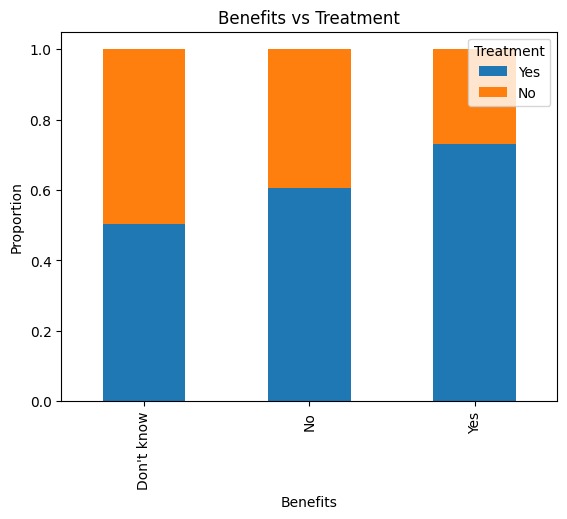

The percentage of employee who received treatment is higher among those who received benefits compared to those who did not receive benefits.


In [15]:
benefit_vs_treatment = pd.crosstab(works_in_tech["benefits"], works_in_tech["treatment"], normalize="index")
if "Yes" in benefit_vs_treatment.columns:
    benefit_vs_treatment = benefit_vs_treatment[["Yes", "No"]]
benefit_vs_treatment.plot(kind="bar", stacked=True)
plt.title("Benefits vs Treatment")
plt.xlabel("Benefits")
plt.ylabel("Proportion")
plt.legend(title="Treatment")
plt.show()
print("The percentage of employee who received treatment is higher among those who received benefits compared to those who did not receive benefits.")

work_interfere,Never,Often,Rarely,Sometimes
treatment,,,,
No,0.506579,0.052632,0.131579,0.309211
Yes,0.045455,0.183794,0.191700,0.579051


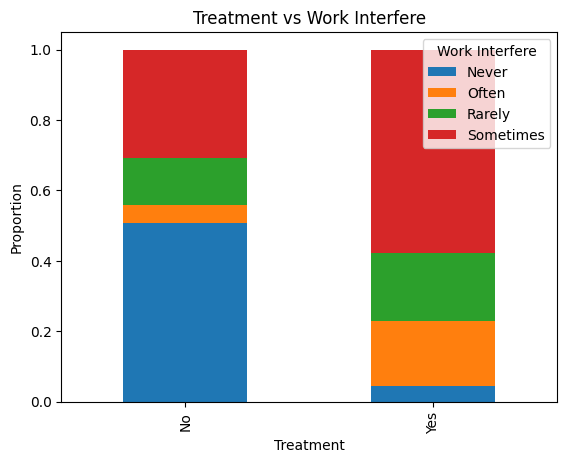

In [16]:
treatment_vs_work_interfere = pd.crosstab(works_in_tech["treatment"], works_in_tech["work_interfere"], normalize="index")
if 1 in treatment_vs_work_interfere.columns:
	treatment_vs_work_interfere = treatment_vs_work_interfere[[1, 0]]
display(treatment_vs_work_interfere)
treatment_vs_work_interfere.plot(kind="bar", stacked=True)
plt.title("Treatment vs Work Interfere")
plt.xlabel("Treatment")
plt.ylabel("Proportion")
plt.legend(title="Work Interfere")
plt.show()

work_interfere,Never,Often,Rarely,Sometimes
benefits,,,,
Don't know,0.304167,0.083333,0.116667,0.495833
No,0.174603,0.182540,0.162698,0.480159
Yes,0.188679,0.135220,0.213836,0.462264


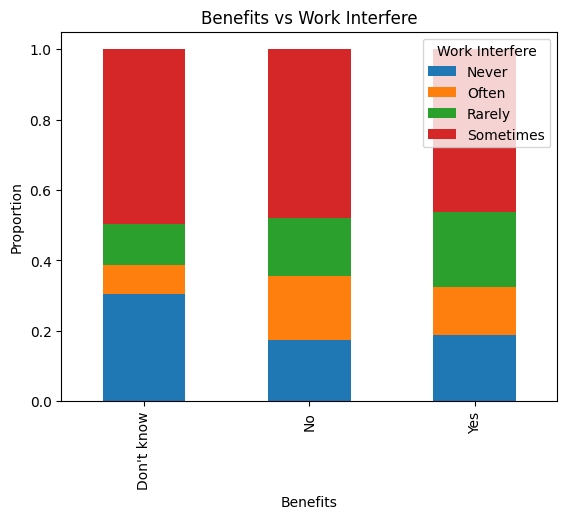

In [17]:
benefit_vs_work_interfere = pd.crosstab(works_in_tech["benefits"], works_in_tech["work_interfere"], normalize="index")
display(benefit_vs_work_interfere)
benefit_vs_work_interfere.plot(kind="bar", stacked=True)
plt.title("Benefits vs Work Interfere")
plt.xlabel("Benefits")
plt.ylabel("Proportion")
plt.legend(title="Work Interfere")
plt.show()